In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import mglearn 
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

# 데이터 EDA

### 데이터 불러오기

In [2]:
df = pd.read_csv('./data/final_dataset.csv', encoding='EUC-KR') # 각자 경로 따라 수정. 인코딩 필요없을수도있음

### 데이터 기초 정보 확인

In [3]:
df.shape  # 전체 900행으로 나타남

(14810, 16)

In [4]:
df.info() 
# 학점 ~ 봉사까지 전부 int나 float이 아닌 object인 것을 확인할 수 있음. 이는 점수 뒤에 붙은 조사 때문으로 보임
# 학점은 float, 나머지는 int로 변환할 필요가 있음

# 또한 전부 non-null이지만 900행이 아닌 열이 일부 관측됨. 기업분류, 지원분야, 전공 분야에 대한 구체적 확인이 필요함

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14810 entries, 0 to 14809
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   기업명     14810 non-null  object
 1   지원분야    13779 non-null  object
 2   학교      14810 non-null  object
 3   전공      12563 non-null  object
 4   학점      14810 non-null  object
 5   토익      14810 non-null  object
 6   오픽      14810 non-null  object
 7   토스      14810 non-null  object
 8   자격증     14809 non-null  object
 9   연수      14810 non-null  object
 10  봉사      14810 non-null  object
 11  인턴      14810 non-null  object
 12  업종      14810 non-null  object
 13  업종분류    14810 non-null  int64 
 14  기업규모    14810 non-null  object
 15  규모분류    14810 non-null  int64 
dtypes: int64(2), object(14)
memory usage: 1.8+ MB


In [5]:
df.describe() # int 타입이 아닌 object 타입이라 제대로 값이 산출되지 않음

,업종분류,규모분류
count,14810.000000,14810.000000
mean,10.605334,2.145037
std,5.317740,1.137411
min,1.000000,1.000000
25%,7.000000,1.000000
50%,11.000000,2.000000
75%,14.000000,3.000000
max,19.000000,4.000000


In [6]:
df.isnull().sum() # 빈 행 갯수만큼 각 열에서 null값이 관측됨. 해당 데이터 결측치에 대한 전처리가 필요할 것으로 판단됨.

기업명        0
지원분야    1031
학교         0
전공      2247
학점         0
토익         0
오픽         0
토스         0
자격증        1
연수         0
봉사         0
인턴         0
업종         0
업종분류       0
기업규모       0
규모분류       0
dtype: int64

In [7]:
null_rows_2 = df[df['학교']=='고졸']
null_rows_2

,기업명,지원분야,학교,전공,학점,토익,오픽,토스,자격증,연수,봉사,인턴,업종,업종분류,기업규모,규모분류
9,아워홈,요리사,고졸,NaN,-,-,-,-,2개,-,-,-,음식료/호텔/리조트/여행,10,중견기업,2
16,21세기조선,생산직종사자,고졸,NaN,-,-,-,-,1개,-,-,-,자동차/기계/조선,12,중소기업,4
32,ADT캡스,회계담당자,고졸,NaN,-,-,-,-,4개,-,-,-,다업종기업/기타,3,중소기업,4
33,ADT캡스,설치·수리기사,고졸,NaN,-,-,-,-,1개,-,-,-,다업종기업/기타,3,중소기업,4
34,ADT캡스,시설관리자,고졸,NaN,-,-,-,-,2개,-,-,-,다업종기업/기타,3,중소기업,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14761,흥아해운,회계담당자,고졸,NaN,-,-,-,-,-,-,-,-,상사/유통/운송,7,중견기업,2
14766,흥아해운,인사담당자,고졸,NaN,-,-,-,-,4개,-,-,-,상사/유통/운송,7,중견기업,2
14792,희성촉매,생산직종사자,고졸,NaN,-,-,-,-,3개,-,-,-,자동차/기계/조선,12,중견기업,2
14796,희성촉매,생산직종사자,고졸,NaN,-,-,-,-,-,-,-,-,자동차/기계/조선,12,중견기업,2


### 데이터 타입 변경 및 기초 전처리

In [8]:
# 영어점수는 토익, 토익스피킹, 오픽중 하나만 따는 경향이 있음. 따라서 비어있는 경우가 많으므로 세 열을 하나로 합치는게 나을 것으로 보임
# 토익스피킹과 오픽 점수는 토익 점수로 환산이 가능함. 따라서 토익 점수 분류에 따라 토익스피킹과 오픽 점수를 변환함
eng = {'-' : 0, 'Lv1' : 100, 'Lv2' : 200, 'Lv3' : 300, 'Lv4' : 440, 'Lv5' : 600, 'Lv6' : 775, 'Lv7' : 915, 'Lv8' : 975,
       'Level 2' : 200, 'Level 4' : 440, 'Level 5' : 600, 'Level 6' : 775, 'Level 7' : 915, 'Level 8' : 975,
       'AL' : 975, 'AM' : 990, 'AH' : 990,
       'IL' : 440, 'IM': 570, 'IM1' : 570, 'IM2' : 745, 'IM3' : 845, '13' : 845, 'IH' : 915,
       'NL' : 100, 'NH' : 300, 'M1' : 570, 'M2' : 745}
df = df.replace(to_replace=eng)

In [9]:
df.head()
# 확인결과 정상적으로 변환된 것을 알 수 있음. 
#단, 일부 열이 아닌 전체 열에 변환과정을 진행한 것으로 타 행에서 '-'가 0으로 변환되었을 수 있음
# 따라서 추후 시각화 과정에서 다른 열, 특히 회사명~전공 등 str 열에 0값이 나타나는지 확인이 필요함
# 특히 결측치가 확인되었었던 전공, 기업분류, 지원분야 열을 주의깊게 확인

,기업명,지원분야,학교,전공,학점,토익,오픽,토스,자격증,연수,봉사,인턴,업종,업종분류,기업규모,규모분류
0,아워홈,법인영업,지방4년제,중국어과,3.5,0,0,0,0,1회,0,0,음식료/호텔/리조트/여행,10,중견기업,2
1,아워홈,재무담당자,수도권4년제,중어중문과,3.57,900점,0,975,4개,2회,0,0,음식료/호텔/리조트/여행,10,중견기업,2
2,아워홈,바이오·제약연구원,대학원,화공생명공학과,4.19,800점,0,775,4개,1회,0,1회,음식료/호텔/리조트/여행,10,중견기업,2
3,아워홈,바이오·제약연구원,대학원,화공생명공학과,4.19,800점,0,775,4개,1회,0,1회,음식료/호텔/리조트/여행,10,중견기업,2
4,아워홈,온라인마케터,수도권4년제,문화경영학과,3.63,950점,0,775,1개,1회,3회,2회,음식료/호텔/리조트/여행,10,중견기업,2


In [10]:
# 숫자형 데이터에서 '점', '개', '회' 등을 떼어내는 코드
df['토익'] = df['토익'].str.extract(r'(\d+)')
df['자격증'] = df['자격증'].str.extract(r'(\d+)')
df['연수'] = df['연수'].str.extract(r'(\d+)')
df['인턴'] = df['인턴'].str.extract(r'(\d+)')
df['봉사'] = df['봉사'].str.extract(r'(\d+)')
df = df.fillna(0)
df = df.astype({'학점' : 'float', '토익':'int32', '자격증':'int32', '연수':'int32', '인턴':'int32', '봉사':'int32'})

In [11]:
df.info() 
# 정상적으로 데이터 타입이 변경되었음을 확인할 수 있음. 
#단, 아까 우려한 대로 결측치가 사라짐. 해당 결측치들에 0값이 들어갔을것으로 추측됨

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14810 entries, 0 to 14809
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   기업명     14810 non-null  object 
 1   지원분야    14810 non-null  object 
 2   학교      14810 non-null  object 
 3   전공      14810 non-null  object 
 4   학점      14810 non-null  float64
 5   토익      14810 non-null  int32  
 6   오픽      14810 non-null  object 
 7   토스      14810 non-null  object 
 8   자격증     14810 non-null  int32  
 9   연수      14810 non-null  int32  
 10  봉사      14810 non-null  int32  
 11  인턴      14810 non-null  int32  
 12  업종      14810 non-null  object 
 13  업종분류    14810 non-null  int64  
 14  기업규모    14810 non-null  object 
 15  규모분류    14810 non-null  int64  
dtypes: float64(1), int32(5), int64(2), object(8)
memory usage: 1.5+ MB


In [12]:
df.describe() 
# 외국어, 해외경험, 인턴, 봉사는 상위 75%값도 눈에띄게 낮으며, 특히 외국어의 경우 상위 75%도 0을 기록함
# 분석에 필수적인 자료가 아닐것으로 판단되므로 제외하는것이 나을것으로 판단됨

,학점,토익,자격증,연수,봉사,인턴,업종분류,규모분류
count,14810.000000,14810.000000,14810.000000,14810.000000,14810.000000,14810.000000,14810.000000,14810.000000
mean,3.367169,578.219514,1.447333,0.376165,0.560162,0.328089,10.605334,2.145037
std,1.101730,394.912070,1.674575,0.775032,1.174863,0.938259,5.317740,1.137411
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,3.390000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000
50%,3.670000,800.000000,1.000000,0.000000,0.000000,0.000000,11.000000,2.000000
75%,3.910000,880.000000,2.000000,1.000000,1.000000,0.000000,14.000000,3.000000
max,4.500000,990.000000,16.000000,14.000000,16.000000,11.000000,19.000000,4.000000


In [13]:
#라벨인코딩하기 위해서 str형변환
#df = df.astype({'학교' : 'str' ,'전공' : 'str' })
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14810 entries, 0 to 14809
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   기업명     14810 non-null  object 
 1   지원분야    14810 non-null  object 
 2   학교      14810 non-null  object 
 3   전공      14810 non-null  object 
 4   학점      14810 non-null  float64
 5   토익      14810 non-null  int32  
 6   오픽      14810 non-null  object 
 7   토스      14810 non-null  object 
 8   자격증     14810 non-null  int32  
 9   연수      14810 non-null  int32  
 10  봉사      14810 non-null  int32  
 11  인턴      14810 non-null  int32  
 12  업종      14810 non-null  object 
 13  업종분류    14810 non-null  int64  
 14  기업규모    14810 non-null  object 
 15  규모분류    14810 non-null  int64  
dtypes: float64(1), int32(5), int64(2), object(8)
memory usage: 1.5+ MB


In [14]:
# 범주형 데이터 라벨 인코딩
# 사용할 열만 라벨 인코딩을 진행함
# 본 분석에서 기업명, 지원분야, 전공은 필요없을것으로 판단되므로 라벨인코딩 해야하는 학교와 전공중 학교만 하면 됨

df=df.drop(['기업명','지원분야','전공'],axis=1)

In [15]:
# object 열 [회사명, 기업분류, 시기, 지원분야, 대학, 계열, 전공] 
# 회사명은 추구 기업 규모와 합쳐져 y값에 들어갈 내용이므로 제외, 기업분류도 분류코드와 내용이 중복되므로 제외
# 지원분야는 고려하지 않을것이므로 제외 , 시기도 시계열분석을 진행하지 않을것이므로 제외
# 따라서 대학, 계열, 전공만 숫자형 데이터로 인코딩을 진행함

#df = df[df.학교 != 0]
#lb = LabelEncoder()
#df['학교'] = lb.fit_transform(df['학교'])

# label 인코딩과 원핫 인코딩중 무얼 사용할지도 생각해보기
# 라벨인코딩의 경우 단순히 라벨링해서 숫자 1부터 쭈루룩 달아주는건데 모델에 따라서 숫자가 높을수록 관련이 높다고 해석될 여지도 있음!

In [16]:
university = {'고졸' : 0, '초대졸' : 1, '지방4년제' : 2, '수도권4년제' : 3, '서울4년제' : 4, '해외대학' : 5, '대학원' : 6}
df = df.replace(to_replace=university)

In [17]:
df.info() # 아까 전공계열에 있던 결측치 갯수만큼 전체 열의 행이 감소한 것을 확인해볼 수 있다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14810 entries, 0 to 14809
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   학교      14810 non-null  int64  
 1   학점      14810 non-null  float64
 2   토익      14810 non-null  int32  
 3   오픽      14810 non-null  object 
 4   토스      14810 non-null  object 
 5   자격증     14810 non-null  int32  
 6   연수      14810 non-null  int32  
 7   봉사      14810 non-null  int32  
 8   인턴      14810 non-null  int32  
 9   업종      14810 non-null  object 
 10  업종분류    14810 non-null  int64  
 11  기업규모    14810 non-null  object 
 12  규모분류    14810 non-null  int64  
dtypes: float64(1), int32(5), int64(3), object(4)
memory usage: 1.2+ MB


In [18]:
df.head() # 대학, 계열, 전공이 성공적으로 인코딩된 것을 확인할 수 있다.

,학교,학점,토익,오픽,토스,자격증,연수,봉사,인턴,업종,업종분류,기업규모,규모분류
0,2,3.50,0,0,0,0,1,0,0,음식료/호텔/리조트/여행,10,중견기업,2
1,3,3.57,900,0,975,4,2,0,0,음식료/호텔/리조트/여행,10,중견기업,2
2,6,4.19,800,0,775,4,1,0,1,음식료/호텔/리조트/여행,10,중견기업,2
3,6,4.19,800,0,775,4,1,0,1,음식료/호텔/리조트/여행,10,중견기업,2
4,3,3.63,950,0,775,1,1,3,2,음식료/호텔/리조트/여행,10,중견기업,2


In [19]:
university = {'중소기업' : 1, '중견기업' : 2, '공기업' : 3, '대기업' : 4}
df = df.replace(to_replace=university)

In [20]:
df=df.drop(['업종','업종분류','규모분류'],axis=1)

In [21]:
df.head()

,학교,학점,토익,오픽,토스,자격증,연수,봉사,인턴,기업규모
0,2,3.50,0,0,0,0,1,0,0,2
1,3,3.57,900,0,975,4,2,0,0,2
2,6,4.19,800,0,775,4,1,0,1,2
3,6,4.19,800,0,775,4,1,0,1,2
4,3,3.63,950,0,775,1,1,3,2,2


In [22]:
# 이후 오류가 발생하지 않도록 칼럼명을 영어로 수정해주자. 시각화에서도 한글이면 깨진다.(별도 코딩으로 나오게할순 있음)
df.columns =['university', 'grade' ,'toeic','Opic','toeic_speaking','license','abroad','volunteer','intern', 'company_size']
df.head()

,university,grade,toeic,Opic,toeic_speaking,license,abroad,volunteer,intern,company_size
0,2,3.50,0,0,0,0,1,0,0,2
1,3,3.57,900,0,975,4,2,0,0,2
2,6,4.19,800,0,775,4,1,0,1,2
3,6,4.19,800,0,775,4,1,0,1,2
4,3,3.63,950,0,775,1,1,3,2,2


In [23]:
# 영어점수를 하나로 취합하여 보는게 나을 것 같다.
df['eng']=df.iloc[:,2:5].max(axis = 1, numeric_only = True)
df=df.drop(['toeic','toeic_speaking','Opic'],axis=1)
df

,university,grade,license,abroad,volunteer,intern,company_size,eng
0,2,3.50,0,1,0,0,2,0
1,3,3.57,4,2,0,0,2,900
2,6,4.19,4,1,0,1,2,800
3,6,4.19,4,1,0,1,2,800
4,3,3.63,1,1,3,2,2,950
...,...,...,...,...,...,...,...,...
14805,1,3.50,0,0,0,0,1,0
14806,4,3.31,0,1,0,0,1,0
14807,1,3.62,0,0,0,0,1,0
14808,1,3.60,2,0,0,0,1,0


In [24]:
df = df[['university','grade', 'eng', 'license', 'abroad','volunteer', 'intern', 'company_size']]

### 시각화(히스토그램)

#### 시각화 1

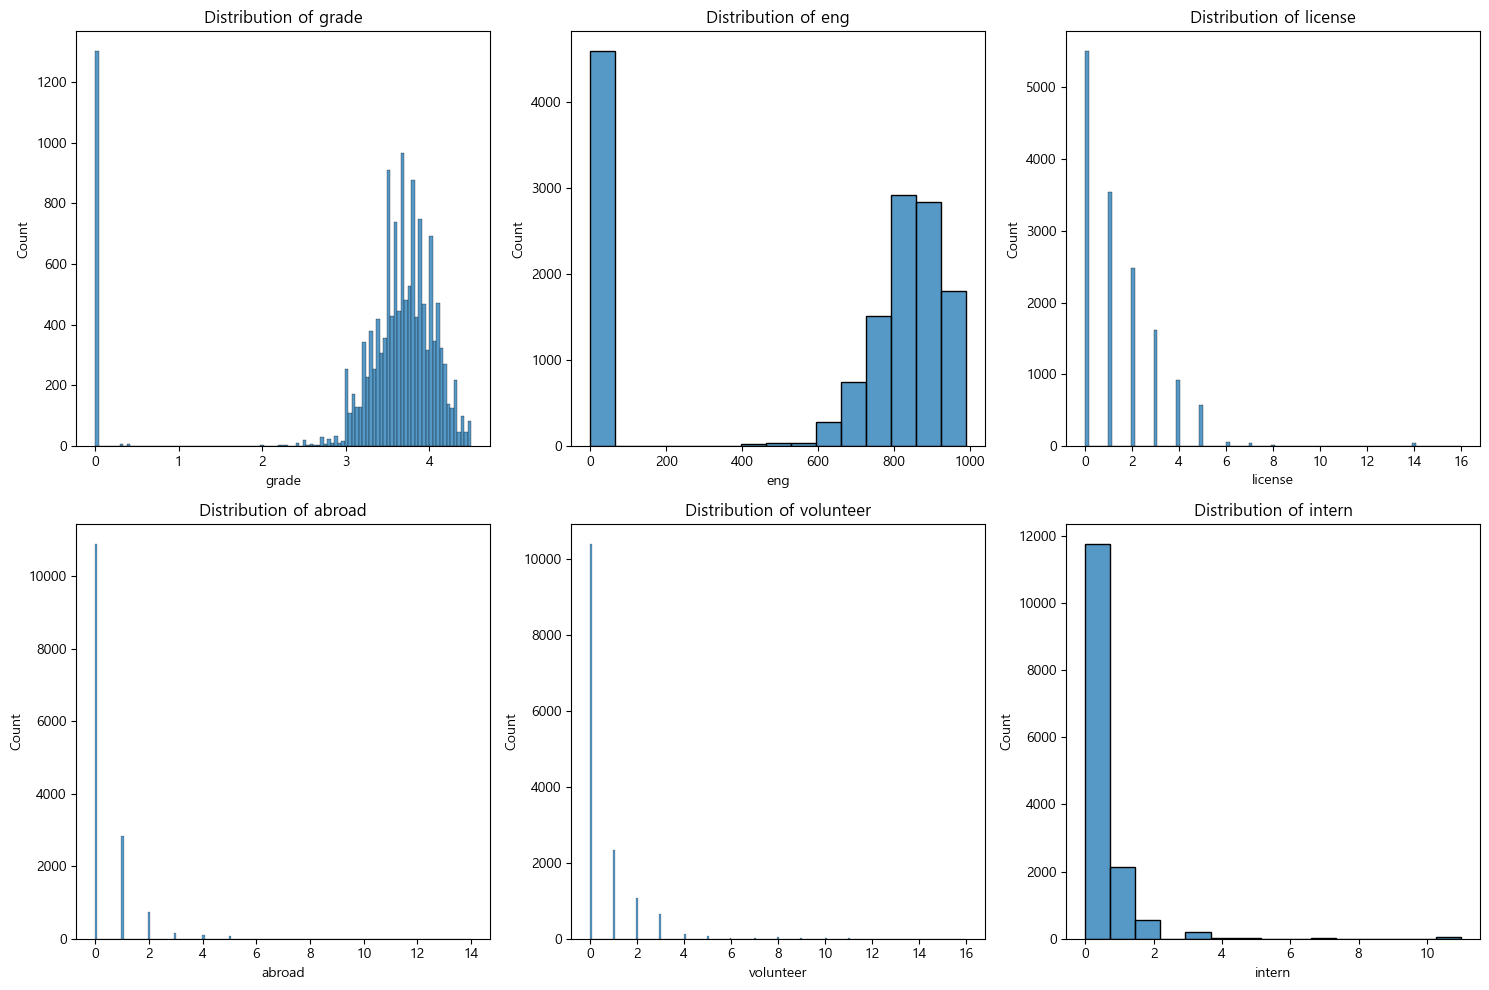

In [25]:
# 수치형 컬럼 분포
num_columns = ['grade', 'eng', 'license', 'abroad','volunteer', 'intern']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, column in enumerate(num_columns):
    sns.histplot(df[column], ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)
    
plt.tight_layout()
plt.show()
# 학점을 보면 0값이 많은 것은 알 수 있다. 학점을 입력하지 않은경우 (고졸이거나~)
# 또한 0이 아닌 0과 1사이 소수점 값인 경우도 있는데, 이는 처리해야할 아웃라이어로 판단된다.

# 그외 해외연수, 인턴쉽, 수상경력등은 거의 0~1 근처에 분포해있으며, 일부 10회 이상이 기록되나 이상치로 보기는 힘듬
# 만일 머신러닝결과 학습이 잘 진행되지 않는다고 판단될 경우 추가적으로 제거. 현재는 문제 없을것으로 보임

# 영어점수의 경우 취합을 했음에도 0점에 분포해 있는 경우가 많음
# 이는 영어점수를 요구하는 기업이 아닐경우 영어점수를 따로 입력하지 않아 발생하는 문제로 판단됨
# 따라서 영어점수 0점은 중앙값으로 대체하는 식으로 이상치를 처리하고자 함

array([[<Axes: title={'center': 'university'}>,
        <Axes: title={'center': 'grade'}>,
        <Axes: title={'center': 'eng'}>],
       [<Axes: title={'center': 'license'}>,
        <Axes: title={'center': 'abroad'}>,
        <Axes: title={'center': 'volunteer'}>],
       [<Axes: title={'center': 'intern'}>,
        <Axes: title={'center': 'company_size'}>, <Axes: >]], dtype=object)

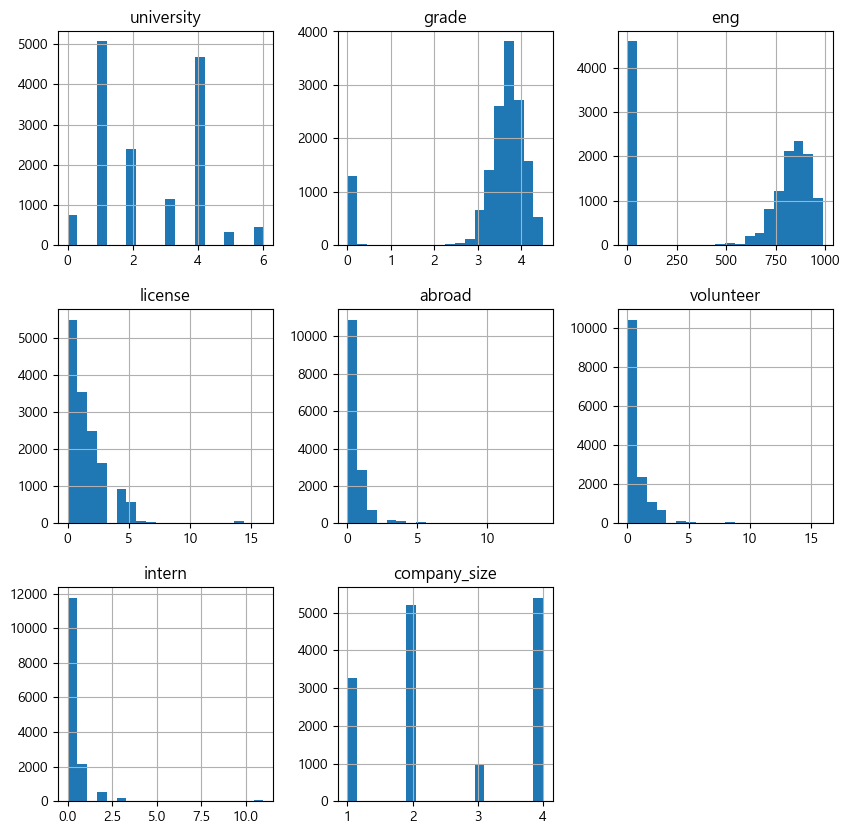

In [26]:
original_df = df
original_df.hist(bins=20, figsize=(10,10))

# 위 히스토그램 해석과 동일

#### 시각화 2 (박스 플롯)

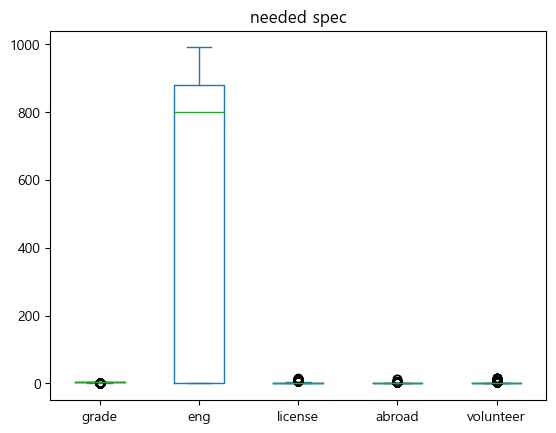

In [27]:
df.iloc[:,1:6].plot(kind = 'box');
plt.title ('needed spec')
plt.show();

# 박스플롯으로 출력한 결과 각각의 데이터 범주가 다르고
# 영어점수의 경우 특히 0~1000점 사이에 분포해 있기 때문에 식별을 위해선 minmaxscaler 등을 이용해 값 분포를 0~1사이에 일치시켜야 할 것으로 보임

# 단, 이때 labelencoder로 라벨링된 대학, 계열, 전공값은 정규화가 진행되지 않도록 주의!

In [28]:
#해당 작업을 하면 예측률이 더 떨어짐
'''
from sklearn.preprocessing import MinMaxScaler
mms =  MinMaxScaler()
df_scaled =  mms.fit_transform(df.iloc[:,1:7])
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns =['grade' , 'eng','license','abroad','volunteer','intern']
df_scaled.plot(kind = 'box');
plt.title ('df_scaled')
plt.show();

df.iloc[:,2:8]=df_scaled.iloc[:,0:6]
'''

"\nfrom sklearn.preprocessing import MinMaxScaler\nmms =  MinMaxScaler()\ndf_scaled =  mms.fit_transform(df.iloc[:,1:7])\ndf_scaled = pd.DataFrame(df_scaled)\ndf_scaled.columns =['grade' , 'eng','license','abroad','volunteer','intern']\ndf_scaled.plot(kind = 'box');\nplt.title ('df_scaled')\nplt.show();\n\ndf.iloc[:,2:8]=df_scaled.iloc[:,0:6]\n"

In [29]:
#df.head(2)

#### 추가적인 데이터 EDA 진행

In [30]:
# 1. 학점 이상치 처리
df3= df[df.grade != 0]
while (df['grade'] < 2).any() or (df['grade'] >= 4.5).any():
    mask = (df['grade'] < 2) | (df['grade'] >= 4.5)
    df.loc[mask, 'grade'] = np.random.normal(df3['grade'].mean(), df3['grade'].std(), mask.sum())

In [31]:
# 2. 영어 이상치 처리
df3= df[df.eng != 0]
while (df['eng'] < 100).any() or (df['eng'] >= 990).any():
    mask = (df['eng'] < 100) | (df['eng'] >= 990)
    df.loc[mask, 'eng'] = np.random.normal(df3['eng'].mean(), df3['eng'].std(), mask.sum())

array([[<Axes: title={'center': 'university'}>,
        <Axes: title={'center': 'grade'}>,
        <Axes: title={'center': 'eng'}>],
       [<Axes: title={'center': 'license'}>,
        <Axes: title={'center': 'abroad'}>,
        <Axes: title={'center': 'volunteer'}>],
       [<Axes: title={'center': 'intern'}>,
        <Axes: title={'center': 'company_size'}>, <Axes: >]], dtype=object)

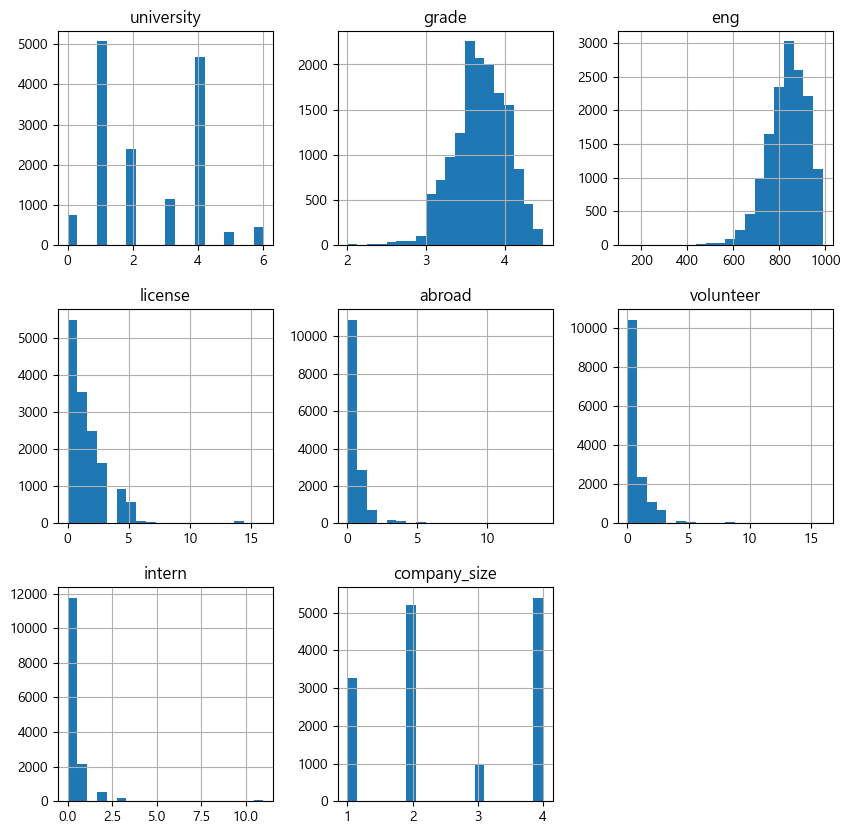

In [32]:
original_df = df
original_df.hist(bins=20, figsize=(10,10))

# 학점과 영어의 이상치가 성공적으로 사라진것을 확인할 수 있다.
# 단 영어점수를 하나로 통일할 때 토익스피킹과 오픽을 레벨에따라 특정값을 부여했더니
# 토익의 평탄화된 정규분포와 합쳐져 중간중간 삐죽삐죽 튀어나오는것을 확인할 수 있다.
# 분석해보고 값이 이상하다면 추가적인 평탄화 작업이 필요할 수 있다.

array([[<Axes: title={'center': 'university'}>,
        <Axes: title={'center': 'grade'}>,
        <Axes: title={'center': 'eng'}>],
       [<Axes: title={'center': 'license'}>,
        <Axes: title={'center': 'abroad'}>,
        <Axes: title={'center': 'volunteer'}>],
       [<Axes: title={'center': 'intern'}>,
        <Axes: title={'center': 'company_size'}>, <Axes: >]], dtype=object)

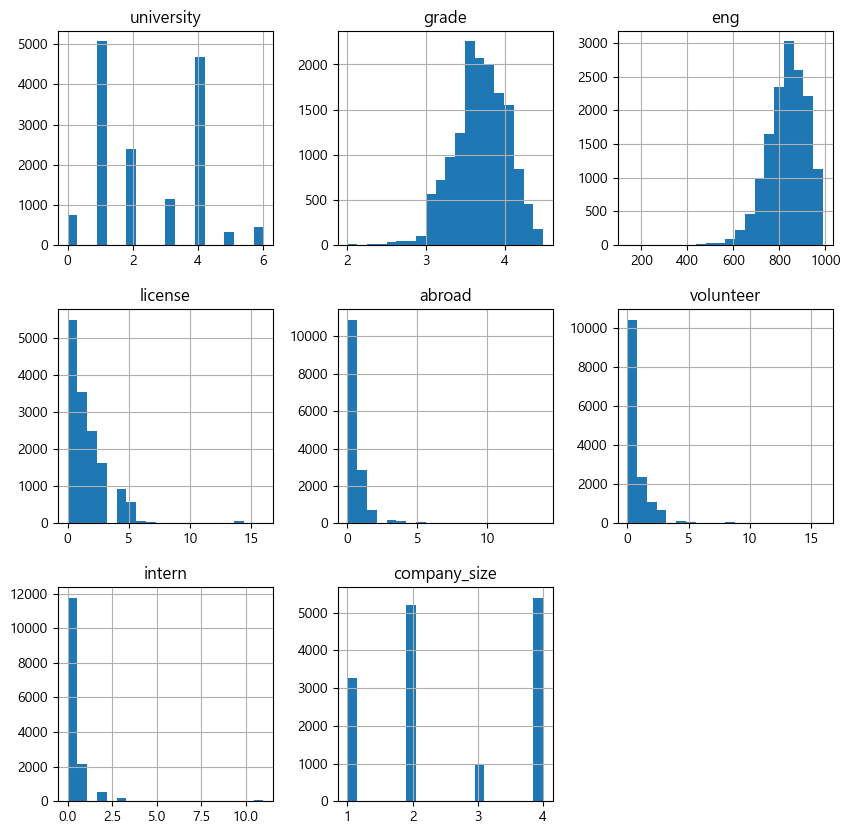

In [33]:
original_df = df
original_df.hist(bins=20, figsize=(10,10))

# 학점과 영어의 이상치가 성공적으로 사라진것을 확인할 수 있다.
# 단 영어점수를 하나로 통일할 때 토익스피킹과 오픽을 레벨에따라 특정값을 부여했더니
# 토익의 평탄화된 정규분포와 합쳐져 중간중간 삐죽삐죽 튀어나오는것을 확인할 수 있다.
# 분석해보고 값이 이상하다면 추가적인 평탄화 작업이 필요할 수 있다.

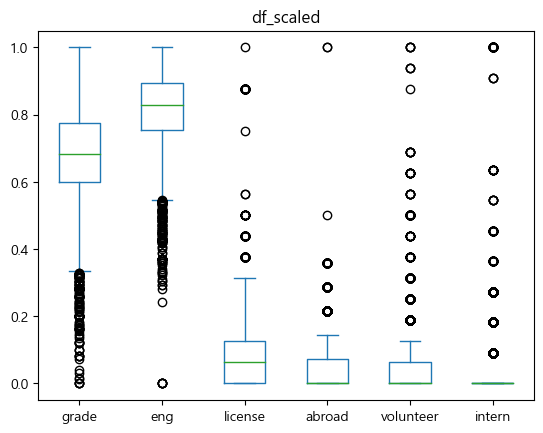

In [34]:
from sklearn.preprocessing import MinMaxScaler
mms =  MinMaxScaler()
df_scaled =  mms.fit_transform(df.iloc[:,1:7])
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns =['grade' , 'eng','license','abroad','volunteer','intern']
df_scaled.plot(kind = 'box');
plt.title ('df_scaled')
plt.show();

In [35]:
df.iloc[:,1:7]=df_scaled.iloc[:,0:6]

In [36]:
df.head(2)

,university,grade,eng,license,abroad,volunteer,intern,company_size
0,2,0.602895,0.715130,0.00,0.071429,0.0,0.0,2
1,3,0.631030,0.894143,0.25,0.142857,0.0,0.0,2


#### 추가 EDA 진행 2 [15]ML 참고

In [37]:
def  std_exclude(df):
    columns  =  df [['grade' , 'eng','license','abroad','volunteer','intern']].columns     
    for col in columns:
        mean = df[col].mean();
        std  = df[col].std(); 
        b = np.abs(df[col]-mean) / std
        df = df[(b < 2 )]     
    return df 
df_scaled_fixed = std_exclude(df)


In [38]:
df_scaled_fixed

,university,grade,eng,license,abroad,volunteer,intern,company_size
0,2,0.602895,0.715130,0.0000,0.071429,0.0000,0.000000,2
2,6,0.880227,0.776492,0.2500,0.071429,0.0000,0.090909,2
3,6,0.880227,0.776492,0.2500,0.071429,0.0000,0.090909,2
6,4,0.602895,0.941203,0.0625,0.000000,0.0625,0.000000,2
7,3,0.711416,0.652959,0.1250,0.000000,0.0000,0.000000,2
...,...,...,...,...,...,...,...,...
14804,1,0.430065,0.668620,0.1875,0.000000,0.0625,0.000000,1
14805,1,0.602895,0.877458,0.0000,0.000000,0.0000,0.000000,1
14806,4,0.526528,0.842782,0.0000,0.071429,0.0000,0.000000,1
14807,1,0.651127,0.642597,0.0000,0.000000,0.0000,0.000000,1


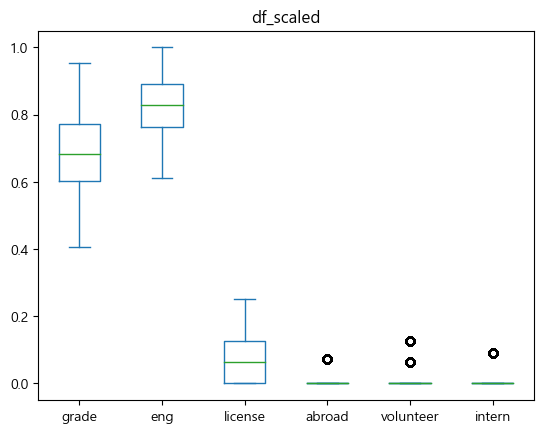

In [39]:
df_scaled_fixed.iloc[:,1:-1].plot(kind = 'box');
plt.title ('df_scaled')
plt.show();

#### 시각화 3 ([8]ML_로지스틱회귀 참고)

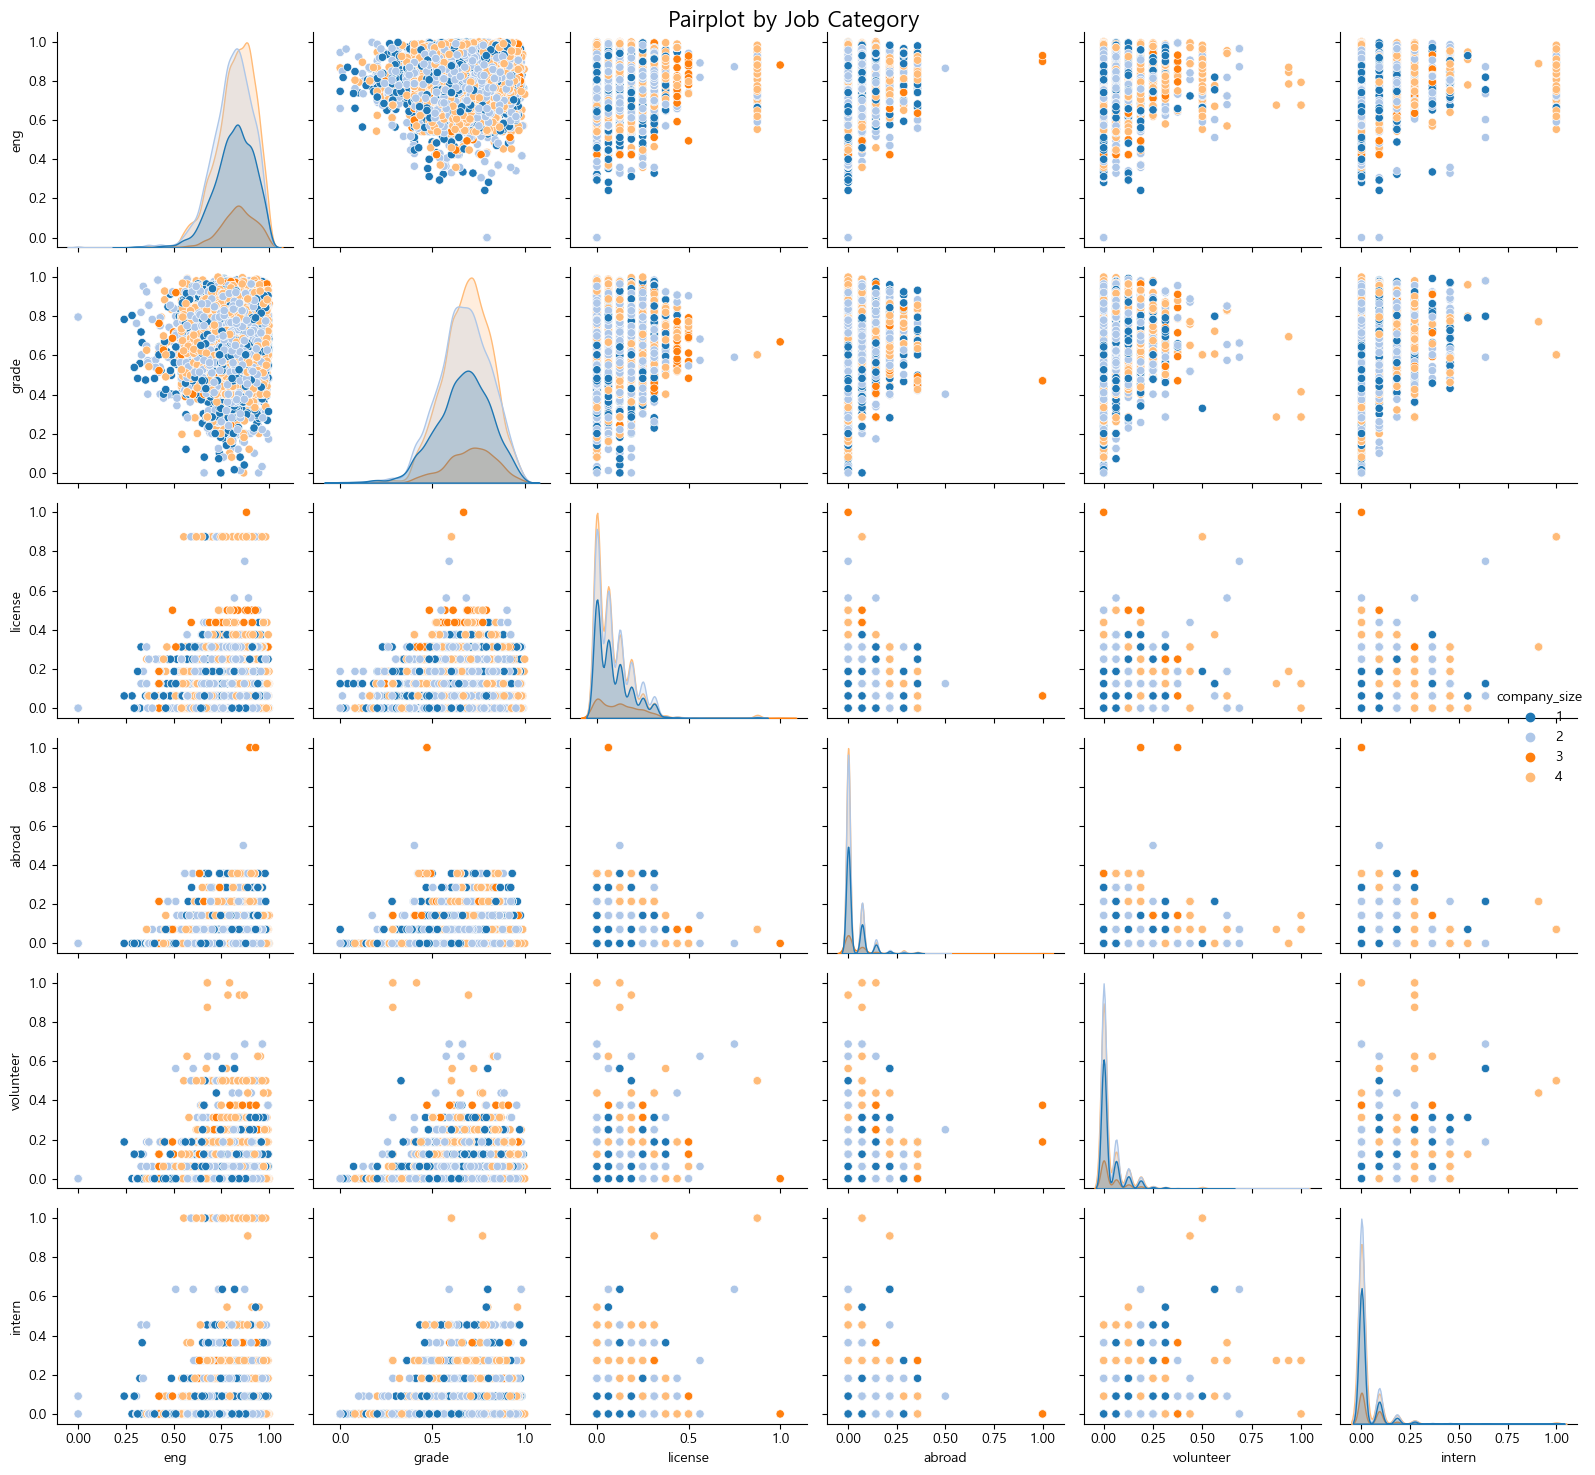

In [40]:
# pairplot 그래프 _ job에 따른 eng, grade, license 상관관계 
sns.pairplot(data=df, vars=['eng', 'grade', 'license','abroad', 'volunteer', 'intern'], hue='company_size', palette='tab20')

plt.suptitle('Pairplot by Job Category', verticalalignment='top', fontsize=16)
plt.tight_layout()
plt.show()

#### 시각화 4 상관관계 분석 (왜 해야하는지 파악하고 하셔야합니다!)

<Axes: >

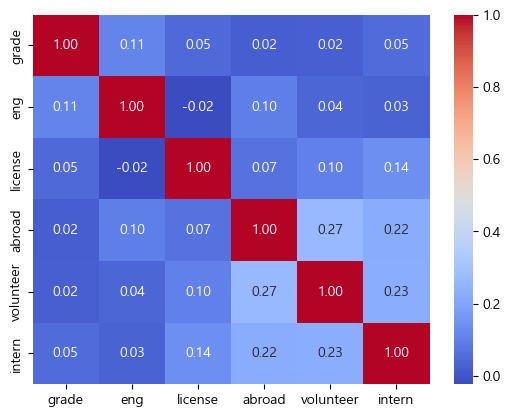

In [41]:
correlation_matrix = df_scaled_fixed.iloc[:,1:7].corr()

# Heatmap으로 상관 관계 시각화
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# 인턴과 봉사 상관관계가 있는것으로 나타나지만
# 대부분의 값이 0이었던 칼럼으로 그저 유사한 형태를 띄는것 판단됨

In [42]:
sampled_data = df_scaled_fixed.sample(frac=0.5, random_state=42 ,axis=0,replace=True)
df2 = pd.concat([df_scaled_fixed, sampled_data], ignore_index=True)

In [43]:
for i in range(50):
    sampled_data = df_scaled_fixed.sample(frac=0.5, random_state=42 ,axis=0,replace=True)
    df2 = pd.concat([df2, sampled_data], ignore_index=True)

array([[<Axes: title={'center': 'university'}>,
        <Axes: title={'center': 'grade'}>,
        <Axes: title={'center': 'eng'}>],
       [<Axes: title={'center': 'license'}>,
        <Axes: title={'center': 'abroad'}>,
        <Axes: title={'center': 'volunteer'}>],
       [<Axes: title={'center': 'intern'}>,
        <Axes: title={'center': 'company_size'}>, <Axes: >]], dtype=object)

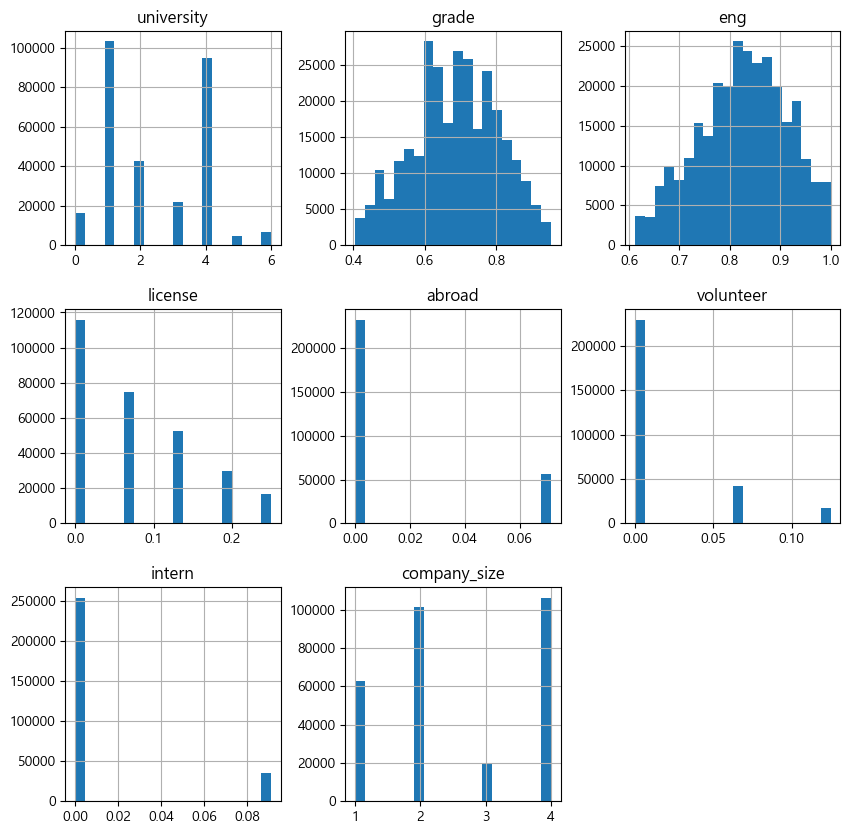

In [44]:
original_df = df2
original_df.hist(bins=20, figsize=(10,10))

In [45]:
df2.iloc[:,:-1]

,university,grade,eng,license,abroad,volunteer,intern
0,2,0.602895,0.715130,0.0000,0.071429,0.0000,0.000000
1,6,0.880227,0.776492,0.2500,0.071429,0.0000,0.090909
2,6,0.880227,0.776492,0.2500,0.071429,0.0000,0.090909
3,4,0.602895,0.941203,0.0625,0.000000,0.0625,0.000000
4,3,0.711416,0.652959,0.1250,0.000000,0.0000,0.000000
...,...,...,...,...,...,...,...
289904,4,0.678550,0.740638,0.2500,0.000000,0.0000,0.000000
289905,2,0.413988,0.629429,0.0000,0.000000,0.0000,0.000000
289906,4,0.675242,0.823553,0.1250,0.000000,0.0000,0.000000
289907,4,0.550644,0.855601,0.0625,0.000000,0.0625,0.000000


In [46]:
df2.iloc[:,-1]

0         2
1         2
2         2
3         2
4         2
         ..
289904    1
289905    4
289906    2
289907    1
289908    4
Name: company_size, Length: 289909, dtype: int64

In [47]:
df

,university,grade,eng,license,abroad,volunteer,intern,company_size
0,2,0.602895,0.715130,0.0000,0.071429,0.0000,0.000000,2
1,3,0.631030,0.894143,0.2500,0.142857,0.0000,0.000000,2
2,6,0.880227,0.776492,0.2500,0.071429,0.0000,0.090909,2
3,6,0.880227,0.776492,0.2500,0.071429,0.0000,0.090909,2
4,3,0.655146,0.952968,0.0625,0.071429,0.1875,0.181818,2
...,...,...,...,...,...,...,...,...
14805,1,0.602895,0.877458,0.0000,0.000000,0.0000,0.000000,1
14806,4,0.526528,0.842782,0.0000,0.071429,0.0000,0.000000,1
14807,1,0.651127,0.642597,0.0000,0.000000,0.0000,0.000000,1
14808,1,0.643088,0.511627,0.1250,0.000000,0.0000,0.000000,1


## 머신러닝 실행

In [48]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV

from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# step 2. 학습 데이터와 검증 데이터로 분리

#X = df[['university','major','grade','eng', 'license','abroad', 'volunteer', 'intern','sector_code']]
#y = df[['size_code']] 
X,y = df2.iloc[:,:-1], df2.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

scores = {}

ctb_clf = CatBoostClassifier(task_type='GPU') 
#ctb_clf = CatBoostClassifier(thread_count=4)
ctb_clf.fit(X_train, y_train)

# 모든 파라미터 확인
all_params = ctb_clf.get_all_params()


results = model_selection.cross_val_score(ctb_clf, X_test, y_test, cv = 5)
scores[('8.CatBoost', 'train_score')] = results.mean()
scores[('8.CatBoost', 'test_score')] = ctb_clf.score(X_test, y_test)

pd.Series(scores).unstack()


Learning rate set to 0.19458
0:	learn: 1.3305358	total: 45.2ms	remaining: 45.1s
1:	learn: 1.2909151	total: 63.6ms	remaining: 31.7s
2:	learn: 1.2617401	total: 80ms	remaining: 26.6s
3:	learn: 1.2407882	total: 97.1ms	remaining: 24.2s
4:	learn: 1.2237325	total: 113ms	remaining: 22.4s
5:	learn: 1.2084827	total: 129ms	remaining: 21.4s
6:	learn: 1.1967763	total: 147ms	remaining: 20.8s
7:	learn: 1.1875411	total: 163ms	remaining: 20.2s
8:	learn: 1.1798111	total: 179ms	remaining: 19.8s
9:	learn: 1.1721893	total: 197ms	remaining: 19.5s
10:	learn: 1.1649132	total: 213ms	remaining: 19.1s
11:	learn: 1.1599940	total: 228ms	remaining: 18.8s
12:	learn: 1.1560401	total: 243ms	remaining: 18.5s
13:	learn: 1.1517055	total: 260ms	remaining: 18.3s
14:	learn: 1.1461439	total: 278ms	remaining: 18.3s
15:	learn: 1.1404096	total: 294ms	remaining: 18.1s
16:	learn: 1.1359760	total: 309ms	remaining: 17.9s
17:	learn: 1.1334162	total: 323ms	remaining: 17.6s
18:	learn: 1.1294660	total: 338ms	remaining: 17.4s
19:	learn:

,test_score,train_score
8.CatBoost,0.913491,0.87806


In [49]:
print("전체 파라미터:", all_params)

전체 파라미터: {'nan_mode': 'Min', 'gpu_ram_part': 0.95, 'eval_metric': 'MultiClass', 'iterations': 1000, 'leaf_estimation_method': 'Newton', 'observations_to_bootstrap': 'TestOnly', 'random_score_type': 'NormalWithModelSizeDecrease', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'devices': '-1', 'eval_fraction': 0, 'pinned_memory_bytes': '104857600', 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'gpu_cat_features_storage': 'GpuRam', 'fold_size_loss_normalization': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'meta_l2_frequency': 0, 'class_names': [1, 2, 3, 4], 'random_seed': 0, 'depth': 6, 'border_count': 128, 'min_fold_size': 100, 'data_partition': 'DocParallel', 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'None', 'leaf_estima

In [50]:
#3-3. 일반화 작업  cross validation(교차검증) -> 과적합과 하이퍼파라미터를 찾자  
from sklearn.model_selection import cross_val_score,KFold

cv  = KFold(n_splits=10, shuffle=True, random_state=42)
results = cross_val_score(ctb_clf, X_train, y_train,cv=cv)
fin_results =  np.mean(results)

type(results)

for i, _  in enumerate(results):
    print('{}번째 교차 검증 정확도 : {} '.format(i,_))
    

print(' 최종  교차 검증 정확도 : {} '.format(fin_results))

Learning rate set to 0.190442
0:	learn: 1.3315287	total: 19.7ms	remaining: 19.6s
1:	learn: 1.2928295	total: 35.9ms	remaining: 17.9s
2:	learn: 1.2638165	total: 51.9ms	remaining: 17.3s
3:	learn: 1.2413919	total: 67.9ms	remaining: 16.9s
4:	learn: 1.2238308	total: 93.5ms	remaining: 18.6s
5:	learn: 1.2105372	total: 112ms	remaining: 18.5s
6:	learn: 1.1985518	total: 128ms	remaining: 18.1s
7:	learn: 1.1872038	total: 143ms	remaining: 17.7s
8:	learn: 1.1787444	total: 158ms	remaining: 17.4s
9:	learn: 1.1718704	total: 172ms	remaining: 17s
10:	learn: 1.1657670	total: 189ms	remaining: 17s
11:	learn: 1.1606780	total: 205ms	remaining: 16.9s
12:	learn: 1.1571844	total: 219ms	remaining: 16.6s
13:	learn: 1.1520413	total: 234ms	remaining: 16.5s
14:	learn: 1.1475207	total: 247ms	remaining: 16.2s
15:	learn: 1.1423137	total: 262ms	remaining: 16.1s
16:	learn: 1.1386093	total: 276ms	remaining: 16s
17:	learn: 1.1348266	total: 290ms	remaining: 15.8s
18:	learn: 1.1310674	total: 304ms	remaining: 15.7s
19:	learn: 1

## 앙상블
#### 각자 진행한 모델학습 취합

##  평가 (RUC/ 커브 그려서 정확도가 얼마나 되는지)

In [51]:
#!pip install scikit_plot